In [1]:
%run C:/Users/MohammedSB/Desktop/projects/Utils/Blacksmith.ipynb

In [2]:
# Seed
set_seed(0)

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

warnings.filterwarnings("ignore")

# Image folder path
path = r"D:\\MohammedSB\Fundus\\"
csv_path = {"htnPath": path + r"HTN", "nonHtnPath": path + "NonHTN"}

# Tune XGBoost

In [5]:
dataset = TabularDataset(csv_path)

In [6]:
X, y = dataset.X, dataset.y
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
boost = xgb.XGBClassifier(tree_method='gpu_hist')

In [8]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

In [9]:
clf = GridSearchCV(estimator=boost, 
                   param_grid=params,
                   scoring='f1', 
                   verbose=1)

# Multimodal

In [4]:
def mm_data():
    csv_path = {"htnPath": path + r"HTN", "nonHtnPath": path + "NonHTN"}
    dataset = HypertensionDataset(csv_path)
    train_set, test_set = split(dataset, train_prcntg=0.8, random=False)
    train_loader, val_loader = data_loader(train_set, test_set, batch_size=1)
    return train_loader, val_loader

In [5]:
csv_path = {"htnPath": path + r"HTN", "nonHtnPath": path + "NonHTN"}
dataset = HypertensionDataset(csv_path)

In [6]:
class FusionModel(torch.nn.Module):
    def __init__(self, image_model, tabular_model, fusion_model, criterion, lr=1e-3, device="cuda:0"):
        super(FusionModel, self).__init__()
        self.image_model = image_model
        self.tabular_model = tabular_model
        self.fusion_model = fusion_model

        # To device
        self.image_model, self.tabular_model, self.fusion_model = self.image_model.to(device), self.tabular_model.to(device), self.fusion_model.to(device)
        
        # Float
        self.image_model, self.tabular_model, self.fusion_model = self.image_model.float(), self.tabular_model.float(), self.fusion_model.float()
        
        # optimizer
        params = itertools.chain(self.tabular_model.parameters(), self.image_model.parameters(), self.fusion_model.parameters()) 
        self.optimizer = torch.optim.Adam([
            {'params': self.tabular_model.parameters(), 'lr': 1e-3},
            {'params': self.image_model.parameters(), 'lr': 1e-5},
            {'params': self.fusion_model.parameters(), 'lr': lr}])
    
        self.criterion = criterion
        self.device = device

## Raytune Optimization

In [4]:
def tune_hp(config):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    if config["model"] == "vgg16":
        model = get_vgg16(device=device, freeze=config['freeze'])
    elif config["model"] == "vgg19":
        model = get_vgg19(device=device, freeze=config['freeze'])
    elif config["model"] == "resnet50":
        model = get_resnet50(device=device)
    elif config["model"] == "resnet152":
        model = get_resnet152(device=device)
    elif config["model"] == "custom":
        model = get_custom(device=device)
    elif config["model"] == "inception_v3":
        model = get_inceptionv3(device=device, freeze=config["freeze"], with_mlp=config["with_mlp"])
    elif config["model"] == "densenet201":
        model = get_densenet201(device=device, freeze=config["freeze"], with_mlp=config["with_mlp"])
    elif config["model"] == "mobilenet_v2":
        model = get_mobilenetv2(device=device, freeze=config["freeze"], with_mlp=config["with_mlp"])
        
#     mlp = get_custom_mlp(device)
#     fs = get_custom_fs(device)
    
    criterion = BCEWithLogitsLoss()
    
#     model = FusionModel(img, mlp, fs, criterion, config["alr"], device)
    
    # Get data
    train_loader, val_loader = config["train_loader"], config["val_loader"]
    
    for epoch in range(1, config["epochs"]):
        # Train
        model.tabular_model.train(True)
        model.image_model.train(True)
        model.fusion_model.train(True)    
        
        with torch.set_grad_enabled(True):
            for sample in train_loader:
                
                img, features, target = sample["image"], sample["features"], sample["label"]
                img, features, target = img.to(device).float(), features.to(device).float(),\
                                        target.to(device).float()
                
                target = target.unsqueeze(dim=-1)                       
                
                # forward
                sig = nn.Sigmoid()
                image_features = model.image_model(img)
                tabular_features = model.tabular_model(features)

                image_pred = sig(image_features)
                tabular_pred = sig(tabular_features)

                # forward pass for fusion
                combined_features = torch.cat((image_pred, tabular_pred), 1)
                output = model.fusion_model(combined_features)   
                    
                loss = model.criterion(output, target)

                # backward
                model.optimizer.zero_grad()
                loss.backward()
                model.optimizer.step()

                    
        # Eval
        model.tabular_model.train(False)
        model.image_model.train(False)
        model.fusion_model.train(False)
        
        metrics = dict()
                
        count, total_loss, correct = 0, 0, 0
        preds, targets = torch.tensor([]), torch.tensor([])
        
        with torch.set_grad_enabled(False):
            for sample in val_loader:
                
                img, features, target = sample["image"], sample["features"], sample["label"]
                img, features, target = img.to(device).float(), features.to(device).float(),\
                                        target.to(device).float()
                
                target = target.unsqueeze(dim=-1)                       
                
                # forward
                sig = nn.Sigmoid()
                image_features = model.image_model(img)
                tabular_features = model.tabular_model(features)

                image_pred = sig(image_features)
                tabular_pred = sig(tabular_features)

                # forward pass for fusion
                combined_features = torch.cat((image_pred, tabular_pred), 1)
                output = model.fusion_model(combined_features)   
                    
                output = model.tabular_model(features)
                loss = model.criterion(output, target)
                
                # bookkeeping
                total_loss += loss * len(img)
                sig = torch.nn.Sigmoid()    
                pred = sig(output.to('cpu').detach())
                pred = map(classify, pred)
                pred = torch.tensor(list(pred), device=device)
                correct += (pred == target.squeeze(1)).sum()
            
                pred = pred.cpu()
                target = target.cpu()
                preds = torch.cat((preds, pred))
                targets = torch.cat((targets, target))
                
        metrics["Loss"] = total_loss.item()
        metrics["Average Loss"] = (total_loss.item() / len(val_loader.dataset))
        metrics["Correct"] = correct.item()
        metrics["Accuracy"] = (correct.item() / len(val_loader.dataset)) * 100
        metrics["Size"] = len(val_loader.dataset)
        
        # Precision, Recall, and F1        
        metrics["Precision"] = precision_score(targets, preds, zero_division=1) 
        metrics["Recall"] = recall_score(targets, preds, zero_division=1) 
        metrics["F1 Score"] = f1_score(targets, preds) 
                
        tune.report(loss=(metrics["Average Loss"]), accuracy=metrics["Accuracy"], f1_score=metrics["F1 Score"],\
                    precision=metrics["Precision"], recall=metrics["Recall"])

In [5]:
# Get Data
dataset = HypertensionDataset(csv_path)

# Shuffle
dataset.df = dataset.df.sample(frac=1).reset_index(drop=True)

# Train and test split using indices
train_indices, test_indices = get_indices(dataset.df, sample_ratio=0.2)
train_set = dataset.df.iloc[train_indices].reset_index(drop=True)
train_indices, val_indices = get_indices(train_set, sample_ratio=0.25) 


train_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

In [6]:
config = {
    "batch_size": tune.grid_search([16]),
    "alr": tune.grid_search([5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6]),
    "epochs": 20,
    "freeze": tune.grid_search([True]),
    "model": tune.grid_search(["mobilenet_v2"]),
    "with_mlp": tune.grid_search([False]),
    "train_loader": train_loader,
    "val_loader": val_loader,
}

reporter = CLIReporter(
    metric_columns=["loss", "accuracy", "f1_score", "precision", "recall"],
)

In [7]:
result = tune.run(
    partial(tune_hp_mm),
    resources_per_trial={"gpu": 1},
    config=config,
    progress_reporter=reporter,
)

2023-02-01 16:38:07,476	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2023-02-01 16:38:10,366	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Current time: 2023-02-01 16:38:10 (running for 00:00:00.35)
Memory usage on this node: 16.7/63.9 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/29.02 GiB heap, 0.0/14.51 GiB objects
Result logdir: C:\Users\MohammedSB\ray_results\tune_hp_mm_2023-02-01_16-38-10
Number of trials: 6/6 (5 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+--------+--------------+----------+--------------+------------+
| Trial name             | status   | loc             |    alr |   batch_size | freeze   | model        | with_mlp   |
|------------------------+----------+-----------------+--------+--------------+----------+--------------+------------|
| tune_hp_mm_aaf87_00000 | RUNNING  | 127.0.0.1:20572 | 0.005  |           16 | True     | mobilenet_v2 | False      |
| tune_hp_mm_aaf87_00001 | PENDING  |                 | 0.0001 |           16 | True     | mobilenet_v2 | False      |
| tune_hp_mm_aaf87_00002 | PENDING  |         

2023-02-01 16:38:14,941	ERROR trial_runner.py:993 -- Trial tune_hp_mm_aaf87_00000: Error processing event.
ray.exceptions.RayTaskError(NameError): ray::ImplicitFunc.train() (pid=20572, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 859, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 863, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 810, in ray._raylet.execute_task.function_executor
  File "C:\ProgramData\Anaconda3\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ray\tune\trainable\trainable.py", line 355, in train
    raise skipped from exception_cause(skipped)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ray\tune\trainable\function_tr

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
tune_hp_mm_aaf87_00000,2023-02-01_16-38-14,4b85a82ff7884bc38996d3a42b3d055c,DESKTOP-G9R02TV,127.0.0.1,20572,1675258694,aaf87_00000
tune_hp_mm_aaf87_00001,2023-02-01_16-38-18,a2d4c59de4e04283b7c485afab2821f1,DESKTOP-G9R02TV,127.0.0.1,32248,1675258698,aaf87_00001


2023-02-01 16:38:19,052	WARNING tune.py:705 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-02-01 16:38:19,134	ERROR trial_runner.py:993 -- Trial tune_hp_mm_aaf87_00001: Error processing event.
ray.exceptions.RayTaskError(NameError): ray::ImplicitFunc.train() (pid=32248, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 859, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 863, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 810, in ray._raylet.execute_task.function_executor
  File "C:\ProgramData\Anaconda3\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs

== Status ==
Current time: 2023-02-01 16:38:19 (running for 00:00:08.73)
Memory usage on this node: 17.0/63.9 GiB 
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/29.02 GiB heap, 0.0/14.51 GiB objects
Result logdir: C:\Users\MohammedSB\ray_results\tune_hp_mm_2023-02-01_16-38-10
Number of trials: 6/6 (2 ERROR, 4 PENDING)
+------------------------+----------+-----------------+--------+--------------+----------+--------------+------------+
| Trial name             | status   | loc             |    alr |   batch_size | freeze   | model        | with_mlp   |
|------------------------+----------+-----------------+--------+--------------+----------+--------------+------------|
| tune_hp_mm_aaf87_00002 | PENDING  |                 | 0.0005 |           16 | True     | mobilenet_v2 | False      |
| tune_hp_mm_aaf87_00003 | PENDING  |                 | 1e-05  |           16 | True     | mobilenet_v2 | False      |
| tune_hp_mm_aaf87_00004 | PENDING  |               

2023-02-01 16:38:19,437	ERROR tune.py:773 -- Trials did not complete: [tune_hp_mm_aaf87_00000, tune_hp_mm_aaf87_00001, tune_hp_mm_aaf87_00002, tune_hp_mm_aaf87_00003, tune_hp_mm_aaf87_00004, tune_hp_mm_aaf87_00005]
2023-02-01 16:38:19,438	INFO tune.py:777 -- Total run time: 9.07 seconds (8.73 seconds for the tuning loop).
2023-02-01 16:38:19,438	WARNING tune.py:783 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


In [62]:
result.results_df.to_csv("mobilenetv2.csv")

In [40]:
train_loader, val_loader, test_loader = get_data(batch_size=4) 

torch.Size([3, 500, 500])


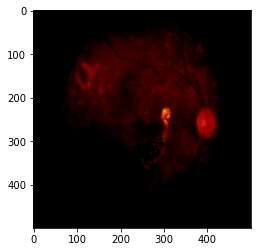

In [50]:
tensor_image = val_loader.dataset[2][0]
print(tensor_image.shape)
tensor_image = tensor_image
plt.imshow(  tensor_image.permute(1, 2, 0))